In [100]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
from pybinding.repository import graphene
from math import pi, sqrt

pb.pltutils.use_style()
%matplotlib inline

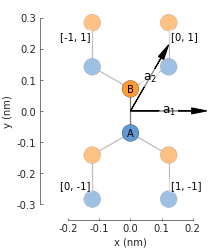

In [101]:
def monolayer_graphene():
    a = 0.24595   # [nm] unit cell length
    a_cc = 0.142  # [nm] carbon-carbon distance
    t = -2.8      # [eV] nearest neighbour hopping

    lat = pb.Lattice(a1=[a, 0],
                     a2=[a/2, a/2 * sqrt(3)])
    lat.add_sublattices(('A', [0, -a_cc/2]),
                        ('B', [0,  a_cc/2]))
    lat.add_hoppings(
        # inside the main cell
        ([0,  0], 'A', 'B', t),
        # between neighboring cells
        ([1, -1], 'A', 'B', t),
        ([0, -1], 'A', 'B', t)
    )
    return lat

lattice = monolayer_graphene()
lattice.plot()
plt.show()

In [102]:
def vacancy(position,size):
    @pb.site_state_modifier
    def modifier(state, x, y):
        x0, y0 = position
        #state[(x-x0)**2 + (y-y0)**2 < radius**2] = False
        print(len(state))
        for i in range(int(len(state)/4), int((len(state)/4*3))) :
            state[(x+size+i)%size==0] = False
        print(state)    
        return state
    return modifier

100
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True]
100
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  Tru

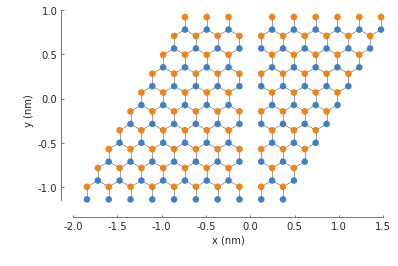

In [103]:
cellSize = 10

model = pb.Model(
    monolayer_graphene(),
    pb.primitive(a1=cellSize,a2=cellSize),
    pb.translational_symmetry(a1=cellSize*0.246,a2=cellSize*0.246),
    vacancy(position=[0,0], size=cellSize)
    
)
model.plot(num_periods=0)
model.lattice.plot_vectors(position=[3.0, -2.0])

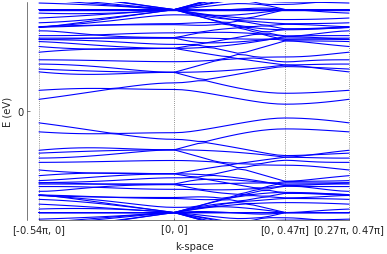

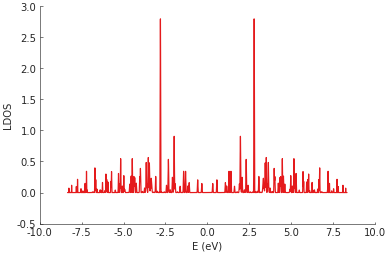

In [104]:
#band structure

solver = pb.solver.lapack(model) # only the 10 lowest states

a_cc = graphene.a_cc
a = graphene.a_cc * sqrt(3)
Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*a_cc*cellSize), 0]
M = [0, 2*pi / (3*a_cc*cellSize)]
K2 = [2*pi / (3*sqrt(3)*a_cc*cellSize), 2*pi / (3*a_cc*cellSize)]


bands = solver.calc_bands(K1, Gamma, M, K2)
bands.plot(linestyle='-',color='b')
plt.ylim(-3,3)
plt.show()

kpm = pb.kpm(model)

ldos = kpm.calc_ldos(energy=np.linspace(-10, 10, 5000), broadening=0.015, position=[0, 0])
ldos.plot()
plt.show()


2681


[]

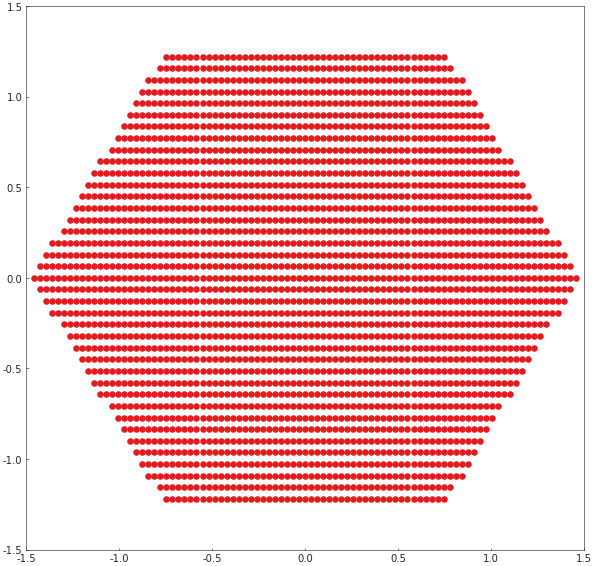

In [105]:


#kd  = (4*pi/3)  # dirac point
a = cellSize*graphene.a
b=2*np.pi/(a) #Reciprocal lattice vector

nn = 20#ncrease this value to increase the sampling of K-points in BZ
pp = 4*nn

nnx = int(round(pp*2/np.sqrt(3)))
ddnx = (2*b/np.sqrt(3))/nnx

nny = int(pp)
ddny = b/nny;

kx1 = np.linspace((-b/np.sqrt(3))-ddnx/2,(b/np.sqrt(3))+ddnx/2,nnx+1)
ky1 = np.linspace(-b-ddny/2,b+ddny/2,nny+1)

bb = b
kk1 = 0

temp1 = np.zeros((round((nnx*nny)*(3/8)),2))
for ii in range (0,nnx):
    for jj in range (0,nny):
        kx = kx1[ii]
        ky = ky1[jj]
        if ((np.sqrt(3)*kx-b)<=ky and (ky<=(-np.sqrt(3)*kx+b)   # this condition make the hexagonal shape
            and (np.sqrt(3)*kx+b)>=ky) and (ky>=-np.sqrt(3)*kx-b)
            and (-b/2<=ky) and (ky<=b/2)):
            kk1 =kk1+1
            temp1[kk1,0] = kx
            temp1[kk1,1] = ky    
            
print(kk1)
#print (temp1)
sample = temp1[0:kk1+1,:] # for nn = 2: 21, nn = 3: 
#print (temp1.shape[0])  # print the number of column
#print (sample)
kx=sample[:,0]
ky=sample[:,1]

plt.figure(figsize=(10,10))
plt.scatter(kx,ky,s=30)
plt.plot()

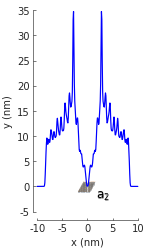

In [106]:
E = 10

#solver.set_wave_vector([0,0])
#lapack_dos = solver.calc_dos(np.linspace(-E, E, 2500), broadening=0.01)
#data2=lapack_dos.data
data2 = 0
for i in range(0,kk1):
    #print(i)
    solver = pb.solver.lapack(model)
    solver.set_wave_vector([kx[i],ky[i]])
    lapack_dos = solver.calc_dos(np.linspace(-E, E, 250), broadening=0.1)##########too large(2500,0.01)
    data2+=lapack_dos.data
data2=data2/(kk1+1)
#plt.plot(data2, np.linspace(-9, 9, 2500),label='position: [4.5,3]',color='b')
plt.plot(np.linspace(-E, E, 250),data2,label='position: [4.5,3]',color='b')
#plt.axvline(-0.02)
#plt.axvline(-0.01)
#plt.ylim(0,10)

model.plot(num_periods=0)
model.lattice.plot_vectors(position=[3.0, -2.0])





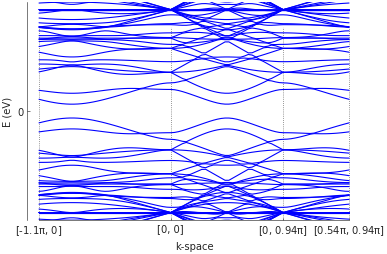

In [107]:
solver = pb.solver.lapack(model) # only the 10 lowest states

a_cc = graphene.a_cc
a = graphene.a_cc * sqrt(3)

Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*a_cc*5), 0]
M = [0, 2*pi / (3*a_cc*5)]
K2 = [2*pi / (3*sqrt(3)*a_cc*5), 2*pi / (3*a_cc*5)]


bands = solver.calc_bands(K1, Gamma, M, K2)
bands.plot(linestyle='-',color='b')
plt.ylim(-3,3)
plt.show()